## Import zone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

## Loading Input File

In [2]:
df = pd.read_csv('../data/01_raw/df_challenge_meli.csv', encoding='latin-1')

## Preprocesamiento

In [3]:
df['seller_reputation_norm'] = df['seller_reputation']
mask = df['seller_reputation'].str.contains('green', na=False)
df.loc[mask, 'seller_reputation_norm'] = 'green'

In [4]:
df['seller_reputation_norm'].value_counts()

seller_reputation_norm
green     159627
newbie      9221
yellow      7245
red         4219
orange      2566
Name: count, dtype: int64

In [5]:
df_sellers = df.groupby('seller_nickname').agg(
    stock_total = ('stock', 'sum'),
    precio_promedio = ('price', 'mean'),
    # pct_green = ('seller_reputation_norm', lambda x: (x == 'green').mean()),
    logistic_type_unique = ('logistic_type', 'nunique'),
    pct_new = ('condition', lambda x: (x == 'new').mean()),
    pct_refurbished = ('is_refurbished', 'mean'),
    categorias_unicas = ('categoria', 'nunique')
).reset_index()

In [6]:
df_sellers.describe()

,stock_total,precio_promedio,logistic_type_unique,pct_new,pct_refurbished,categorias_unicas
count,4.658600e+04,4.633800e+04,46586.000000,46586.000000,46586.000000,46586.000000
mean,1.220859e+03,1.353279e+05,1.126819,0.808661,0.005543,1.698965
std,1.473172e+04,2.236037e+07,0.356445,0.389573,0.070001,1.836275
min,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,1.000000
25%,2.000000e+00,3.154813e+02,1.000000,1.000000,0.000000,1.000000
50%,1.400000e+01,6.631886e+02,1.000000,1.000000,0.000000,1.000000
75%,1.030000e+02,1.783173e+03,1.000000,1.000000,0.000000,2.000000
max,1.066366e+06,4.772354e+09,4.000000,1.000000,1.000000,48.000000


Los outliers de **price** y **stock** pueden jalar los centros de los clústeres y distorsionar los resultados.

### Capping

In [7]:
# Calcula el percentil 99 para cada columna
price_cap = df_sellers['precio_promedio'].quantile(0.99)
stock_cap = df_sellers['stock_total'].quantile(0.99)

print(f"Tope de precio (percentil 99): {price_cap}")
print(f"Tope de stock (percentil 99): {stock_cap}")

# Aplica el capping creando nuevas columnas
df_sellers['price_capped'] = df_sellers['precio_promedio'].clip(upper=price_cap)
df_sellers['stock_capped'] = df_sellers['stock_total'].clip(upper=stock_cap)

# Ahora puedes usar 'price_capped' y 'stock_capped' para la clusterización.
print("\nEstadísticas de la columna de precios original:")
print(df_sellers['precio_promedio'].describe())

print("\nEstadísticas de la columna de precios con capping:")
print(df_sellers['price_capped'].describe())

Tope de precio (percentil 99): 60062.99999999974
Tope de stock (percentil 99): 19509.350000000013

Estadísticas de la columna de precios original:
count    4.633800e+04
mean     1.353279e+05
std      2.236037e+07
min      0.000000e+00
25%      3.154813e+02
50%      6.631886e+02
75%      1.783173e+03
max      4.772354e+09
Name: precio_promedio, dtype: float64

Estadísticas de la columna de precios con capping:
count    46338.000000
mean      2818.003201
std       7801.614356
min          0.000000
25%        315.481250
50%        663.188636
75%       1783.173000
max      60063.000000
Name: price_capped, dtype: float64


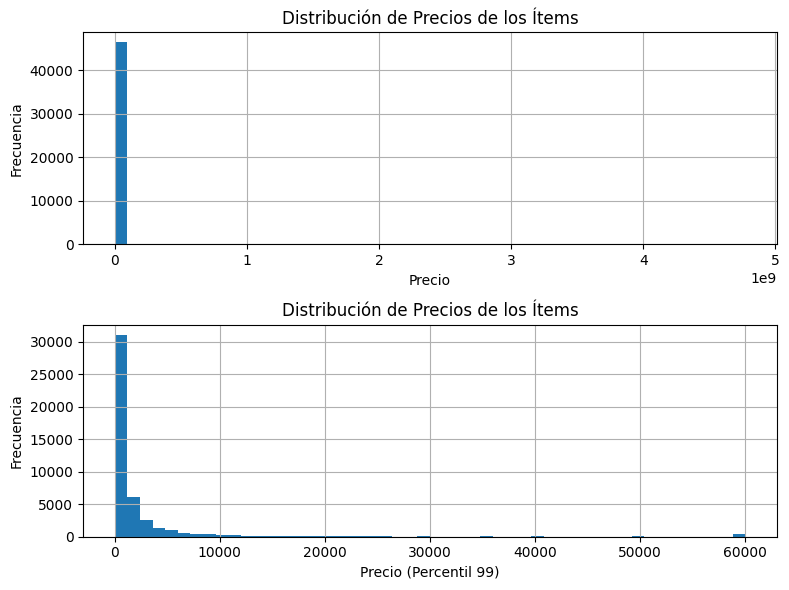

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# Dibujar el primer gráfico en el primer eje (axs[0])
axs[0].hist(df_sellers['precio_promedio'], bins=50)
axs[0].set_title('Distribución de Precios de los Ítems')
axs[0].set_xlabel('Precio')
axs[0].set_ylabel('Frecuencia')
axs[0].grid(True) # Añadir cuadrícula

# Dibujar el segundo gráfico en el segundo eje (axs[1])
axs[1].hist(df_sellers['price_capped'], bins=50)
axs[1].set_title('Distribución de Precios de los Ítems')
axs[1].set_xlabel('Precio (Percentil 99)')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(True) # Añadir cuadrícula

# Ajustar el diseño para evitar solapamiento de títulos y etiquetas
plt.tight_layout()

# Mostrar la figura con ambos gráficos
plt.show()

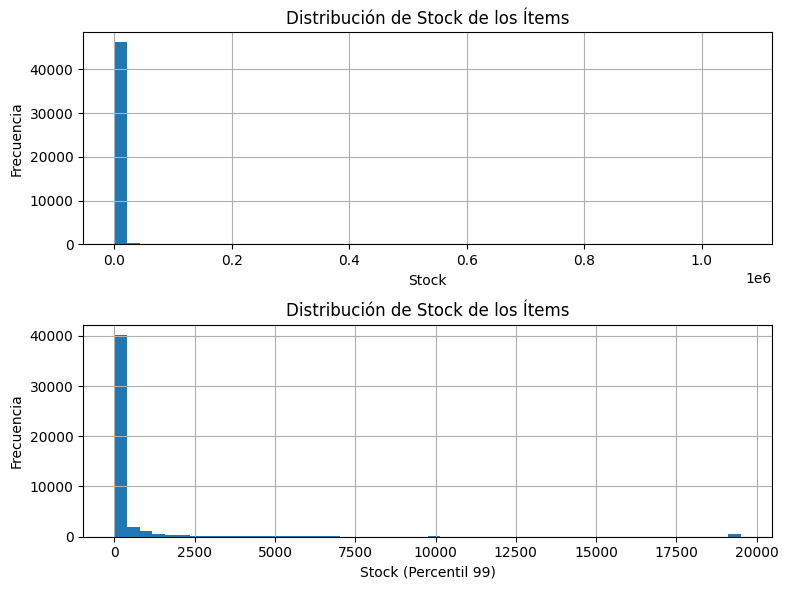

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# Dibujar el primer gráfico en el primer eje (axs[0])
axs[0].hist(df_sellers['stock_total'], bins=50)
axs[0].set_title('Distribución de Stock de los Ítems')
axs[0].set_xlabel('Stock')
axs[0].set_ylabel('Frecuencia')
axs[0].grid(True) # Añadir cuadrícula

# Dibujar el segundo gráfico en el segundo eje (axs[1])
axs[1].hist(df_sellers['stock_capped'], bins=50)
axs[1].set_title('Distribución de Stock de los Ítems')
axs[1].set_xlabel('Stock (Percentil 99)')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(True) # Añadir cuadrícula

# Ajustar el diseño para evitar solapamiento de títulos y etiquetas
plt.tight_layout()

# Mostrar la figura con ambos gráficos
plt.show()

### Transformación Logarítmica

In [10]:
df_sellers['price_log'] = np.log1p(df_sellers['price_capped'])
df_sellers['stock_log'] = np.log1p(df_sellers['stock_capped'])

print("\nEstadísticas de la columna de precios con capping y log:")
df_sellers['price_log'].describe()


Estadísticas de la columna de precios con capping y log:


count    46338.000000
mean         6.719720
std          1.364436
min          0.000000
25%          5.757264
50%          6.498566
75%          7.486710
max         11.003166
Name: price_log, dtype: float64

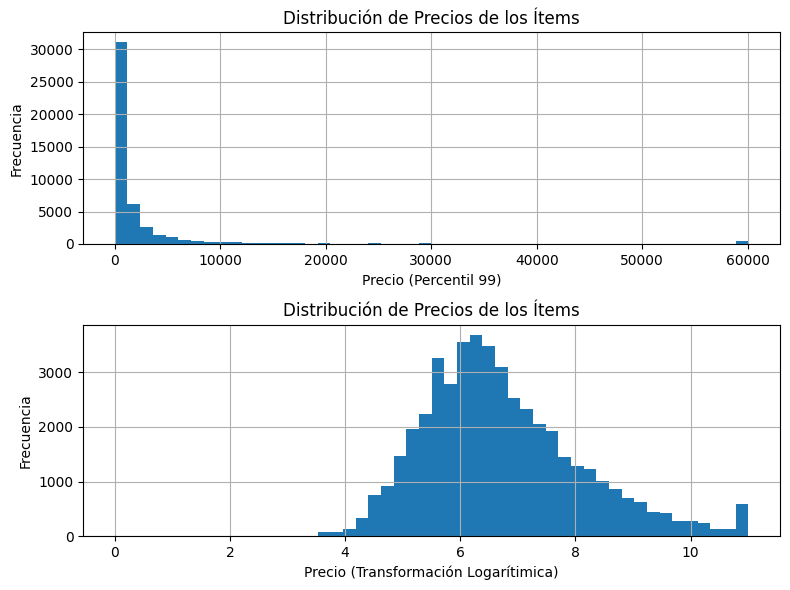

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].hist(df_sellers['price_capped'], bins=50)
axs[0].set_title('Distribución de Precios de los Ítems')
axs[0].set_xlabel('Precio (Percentil 99)')
axs[0].set_ylabel('Frecuencia')
axs[0].grid(True) 

axs[1].hist(df_sellers['price_log'], bins=50)
axs[1].set_title('Distribución de Precios de los Ítems')
axs[1].set_xlabel('Precio (Transformación Logarítimica)')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(True) 

# Ajustar el diseño para evitar solapamiento de títulos y etiquetas
plt.tight_layout()

# Mostrar la figura con ambos gráficos
plt.show()

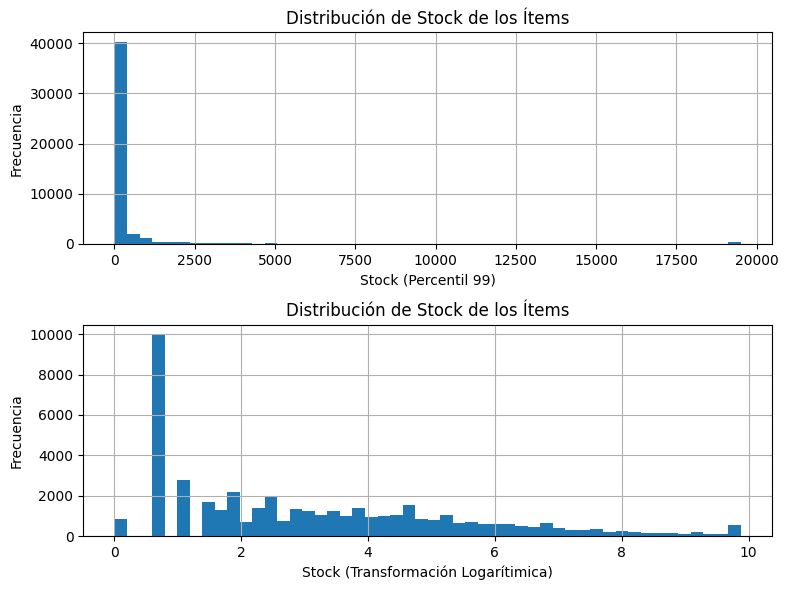

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].hist(df_sellers['stock_capped'], bins=50)
axs[0].set_title('Distribución de Stock de los Ítems')
axs[0].set_xlabel('Stock (Percentil 99)')
axs[0].set_ylabel('Frecuencia')
axs[0].grid(True) 

axs[1].hist(df_sellers['stock_log'], bins=50)
axs[1].set_title('Distribución de Stock de los Ítems')
axs[1].set_xlabel('Stock (Transformación Logarítimica)')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(True) 

# Ajustar el diseño para evitar solapamiento de títulos y etiquetas
plt.tight_layout()

# Mostrar la figura con ambos gráficos
plt.show()

## Escalado y estandarización

In [13]:
features_for_clustering = [
    'stock_total',
    'precio_promedio',
    'logistic_type_unique',
    # 'pct_green',
    'pct_new',
    'pct_refurbished',
    'categorias_unicas'
]

data_to_scale = df_sellers[features_for_clustering]

scaler = StandardScaler()
scaled_data_array = scaler.fit_transform(data_to_scale)
df_scaled = pd.DataFrame(scaled_data_array, columns=features_for_clustering)

In [14]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46586 entries, 0 to 46585
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stock_total           46586 non-null  float64
 1   precio_promedio       46338 non-null  float64
 2   logistic_type_unique  46586 non-null  float64
 3   pct_new               46586 non-null  float64
 4   pct_refurbished       46586 non-null  float64
 5   categorias_unicas     46586 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


## Manejo de Valores Faltantes

In [15]:
# --------------------------------------------------
# --- PASO ADICIONAL: Manejo de Valores Faltantes (NaN) ---
# --------------------------------------------------
# El error 'Input X contains NaN' ocurre porque KMeans no puede
# trabajar con datos faltantes. Se rellenará cualquier valor NaN
# con la mediana de su respectiva columna antes de continuar.
if df_scaled.isnull().sum().any():
    print("Se encontraron valores NaN. Rellenando con la mediana...")
    # Itera sobre cada columna del DataFrame
    for column in df_scaled.columns:
        if df_scaled[column].isnull().any():
            # Calcula la mediana de la columna actual
            median_value = df_scaled[column].median()
            # Rellena los NaN en esa columna con la mediana
            df_scaled[column] = df_scaled[column].fillna(median_value)
    print("Valores NaN rellenados exitosamente.")
else:
    print("No se encontraron valores NaN. El DataFrame está limpio.")


Se encontraron valores NaN. Rellenando con la mediana...
Valores NaN rellenados exitosamente.


In [16]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46586 entries, 0 to 46585
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stock_total           46586 non-null  float64
 1   precio_promedio       46586 non-null  float64
 2   logistic_type_unique  46586 non-null  float64
 3   pct_new               46586 non-null  float64
 4   pct_refurbished       46586 non-null  float64
 5   categorias_unicas     46586 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


## Exportar df procesado

In [17]:
df_scaled.head()

,stock_total,precio_promedio,logistic_type_unique,pct_new,pct_refurbished,categorias_unicas
0,-0.082195,-0.006016,-0.355793,0.491155,-0.07918,-0.380647
1,-0.079140,-0.006034,-0.355793,0.491155,-0.07918,-0.380647
2,-0.082874,-0.006035,-0.355793,0.491155,-0.07918,-0.380647
3,-0.082534,-0.005983,-0.355793,-2.075784,-0.07918,-0.380647
4,-0.082466,-0.006032,2.449722,0.491155,-0.07918,0.163939


In [18]:
df_scaled.to_csv('../data/02_processed/df_scaled.csv', index=False, encoding='latin-1')
df_sellers.to_csv('../data/02_processed/df_sellers.csv', index=False, encoding='latin-1')